In [146]:
library(dplyr)
library(ggplot2)

setwd("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM")

source("/mnt/lareaulab/reliscu/code/ggplot_theme.R")

theme_set(default_theme())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Verify enriched modules actually represent a given cell type by plotting cell type abundance vs. the module eigengene

In [ ]:
pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")


In [16]:
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# Round 1 enrichment results

In [56]:
top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_top_Qval_module.csv")

ctypes <- top_qval_mods_df$Cell_type 

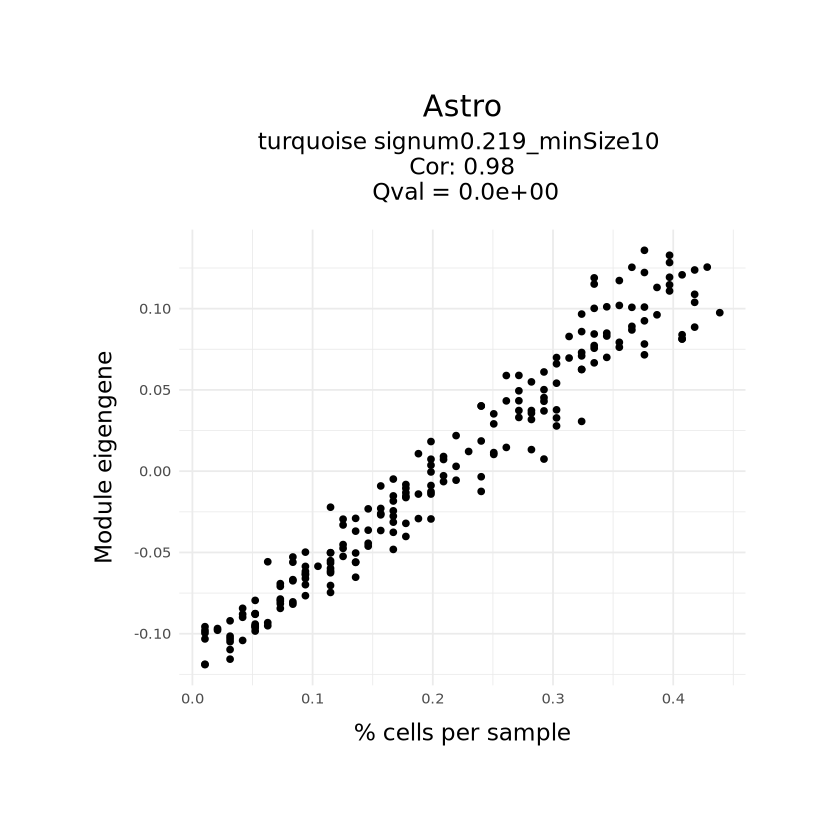

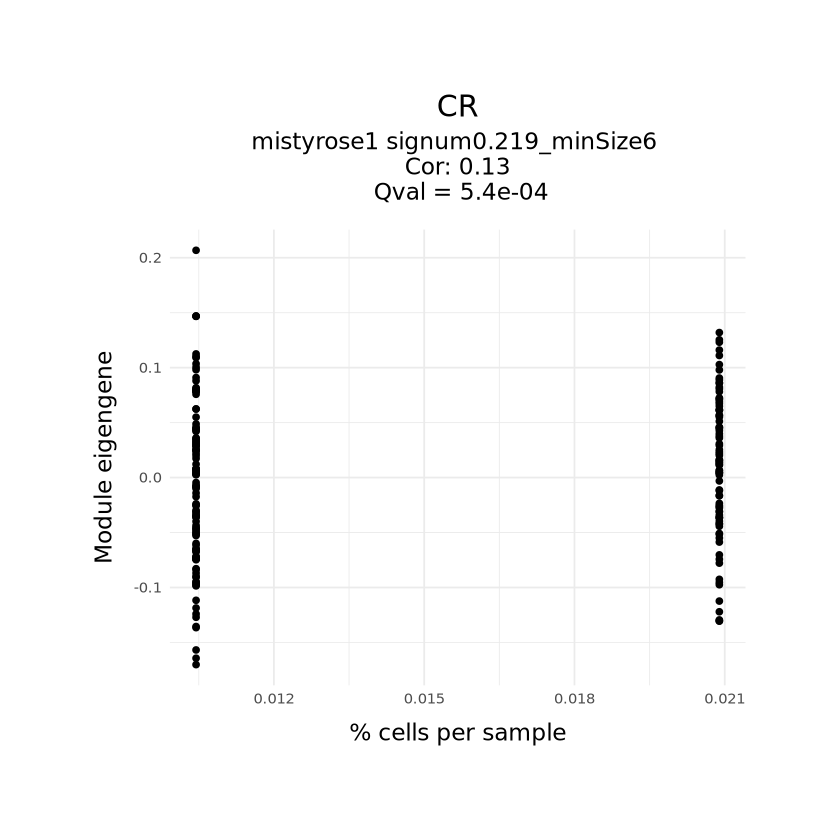

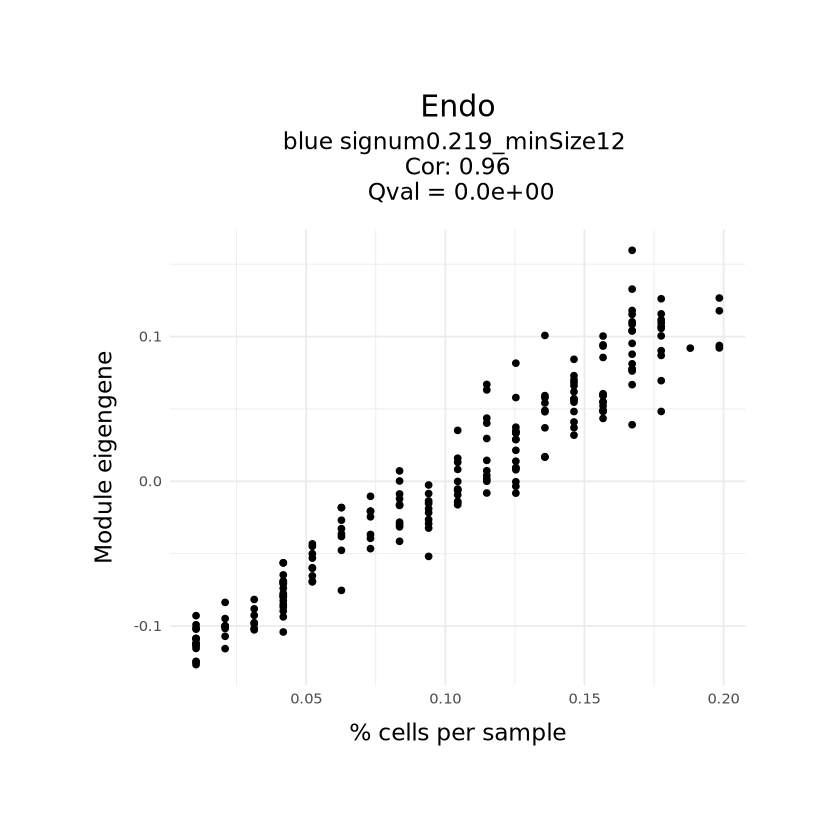

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


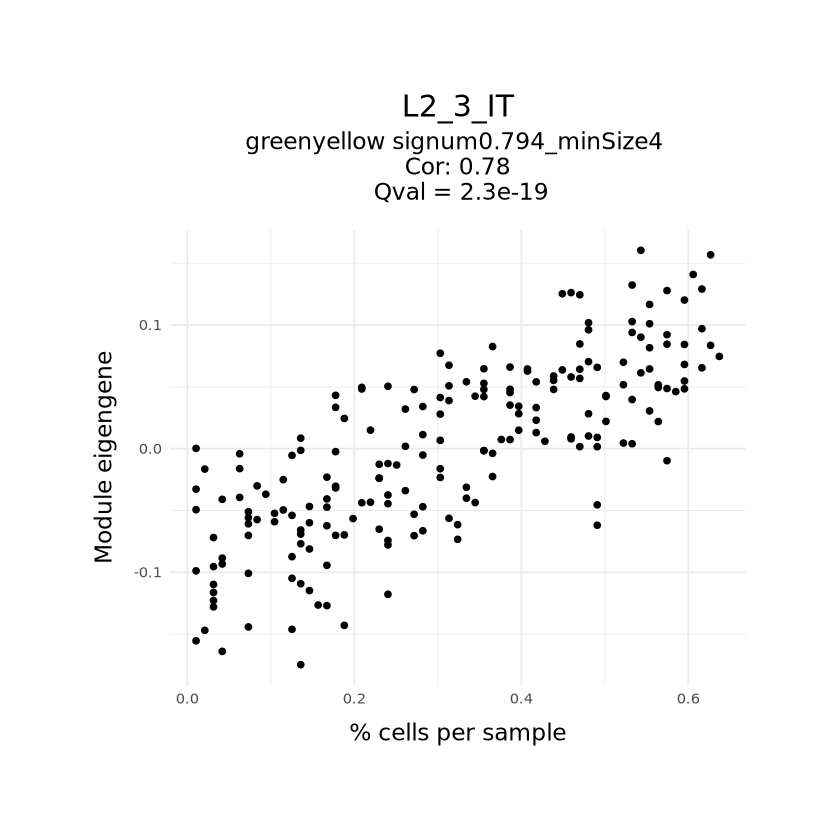

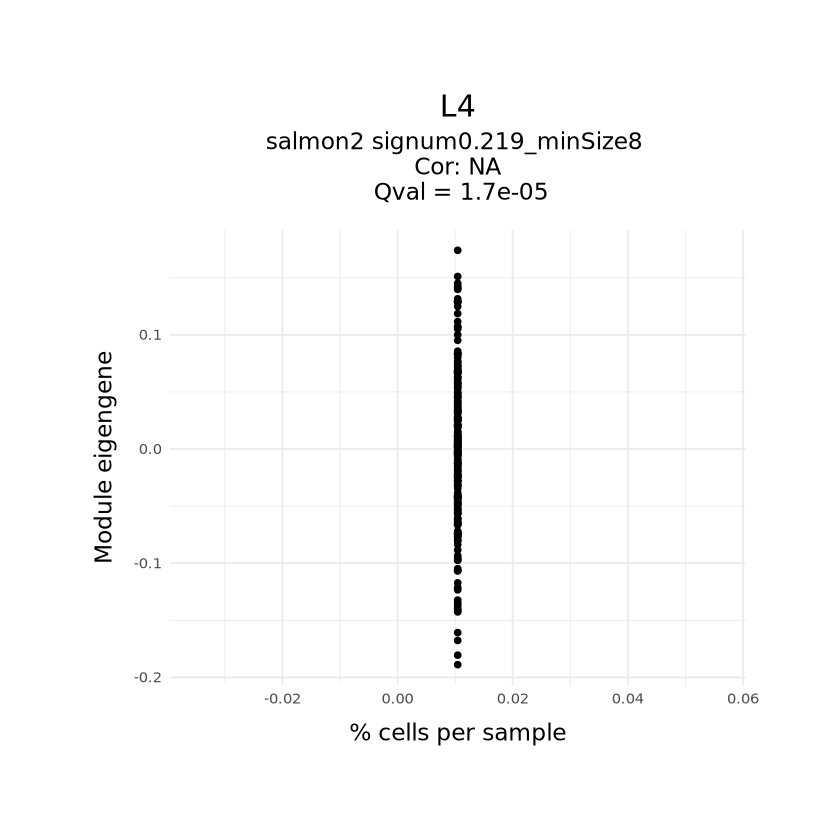

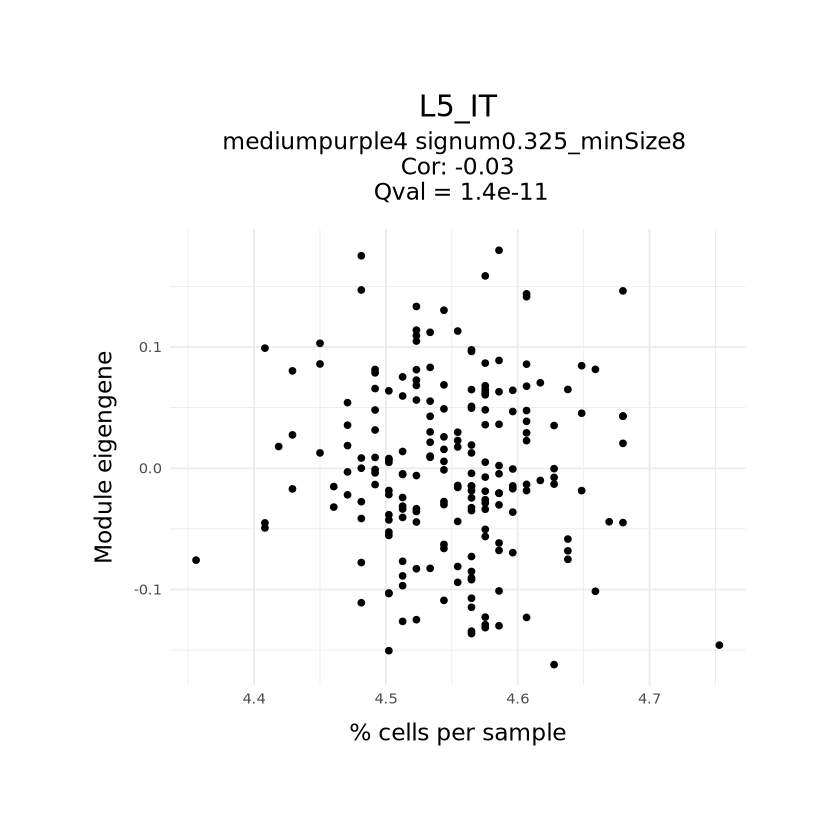

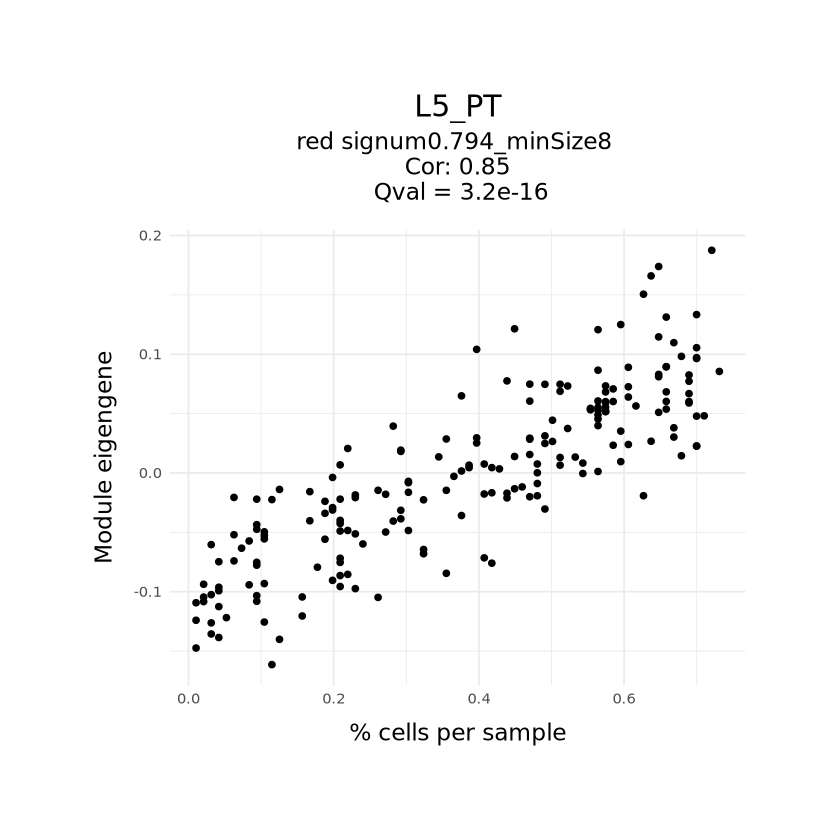

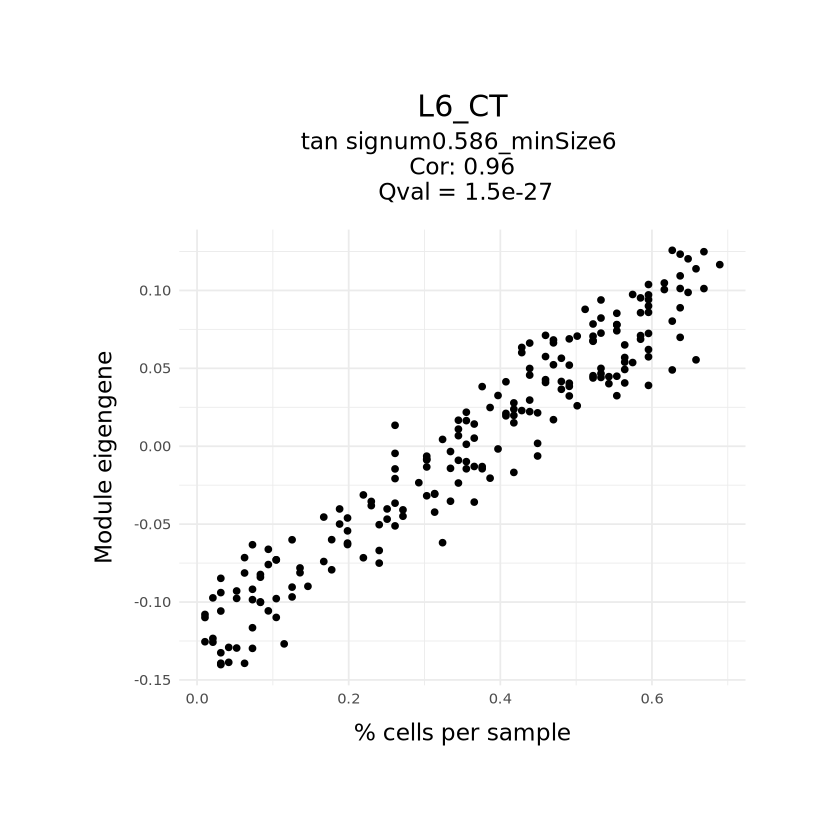

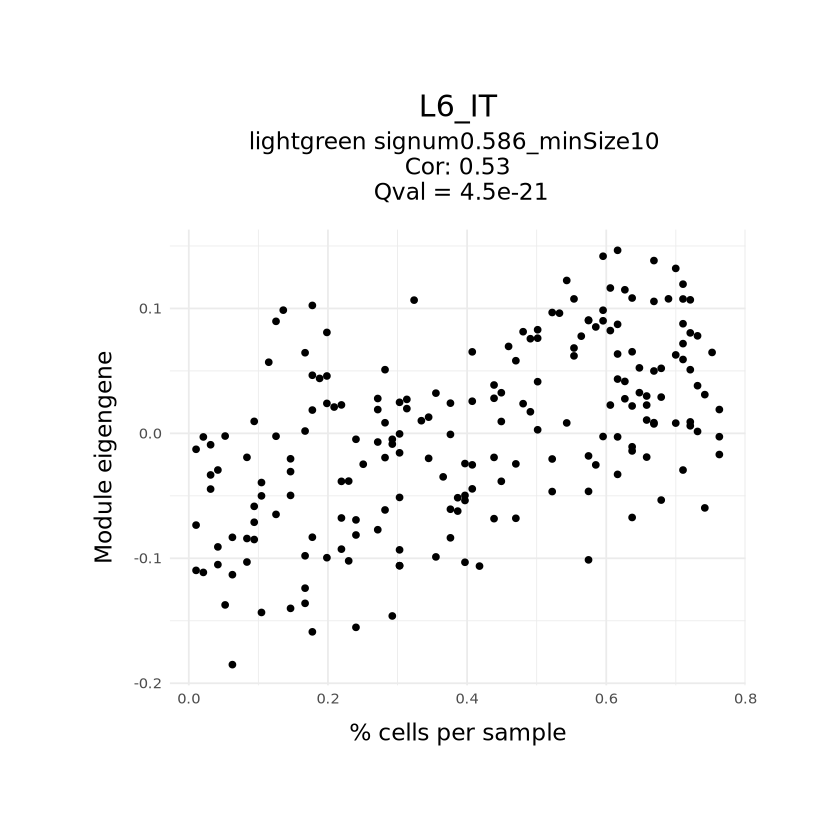

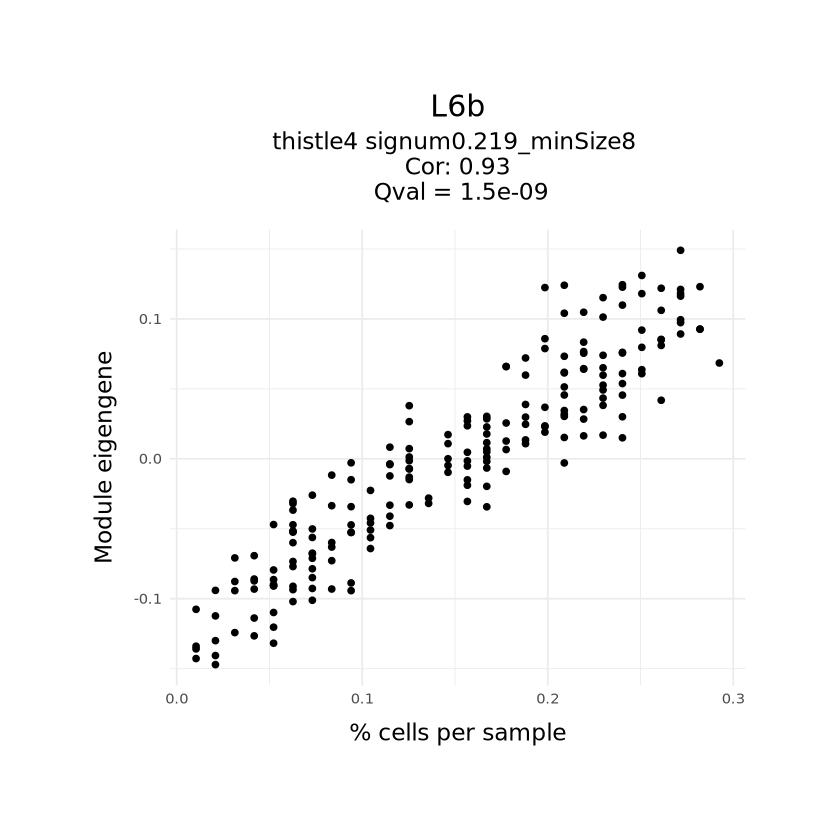

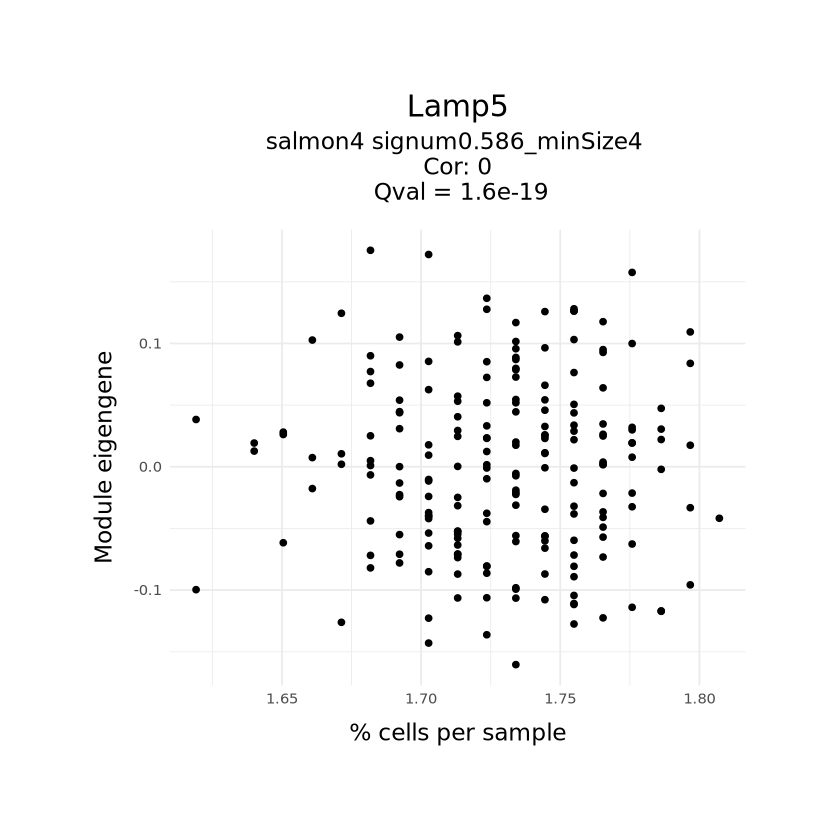

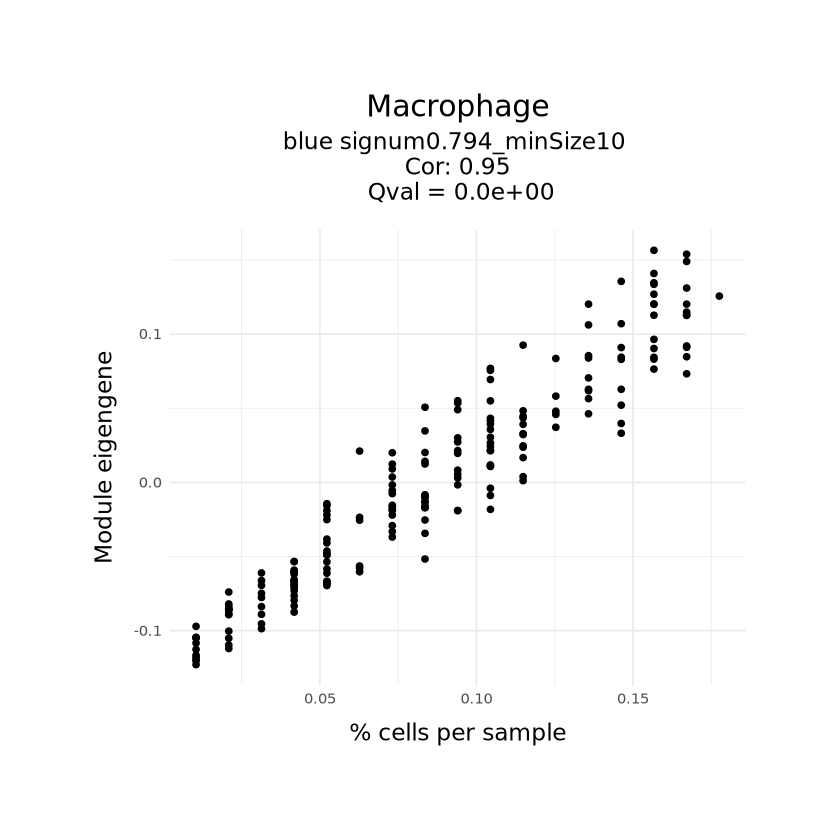

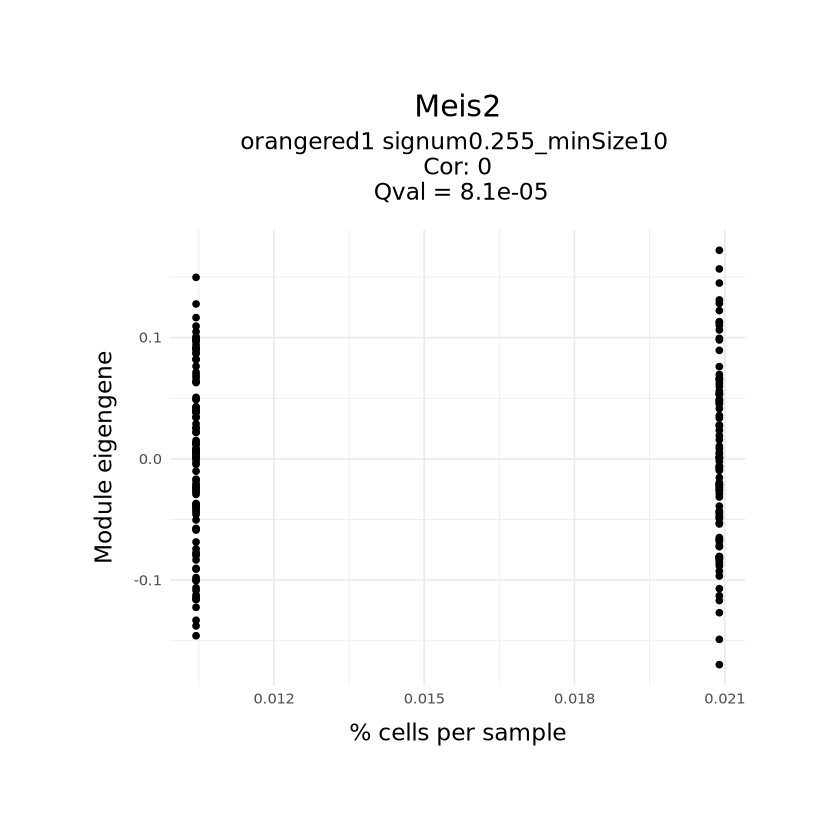

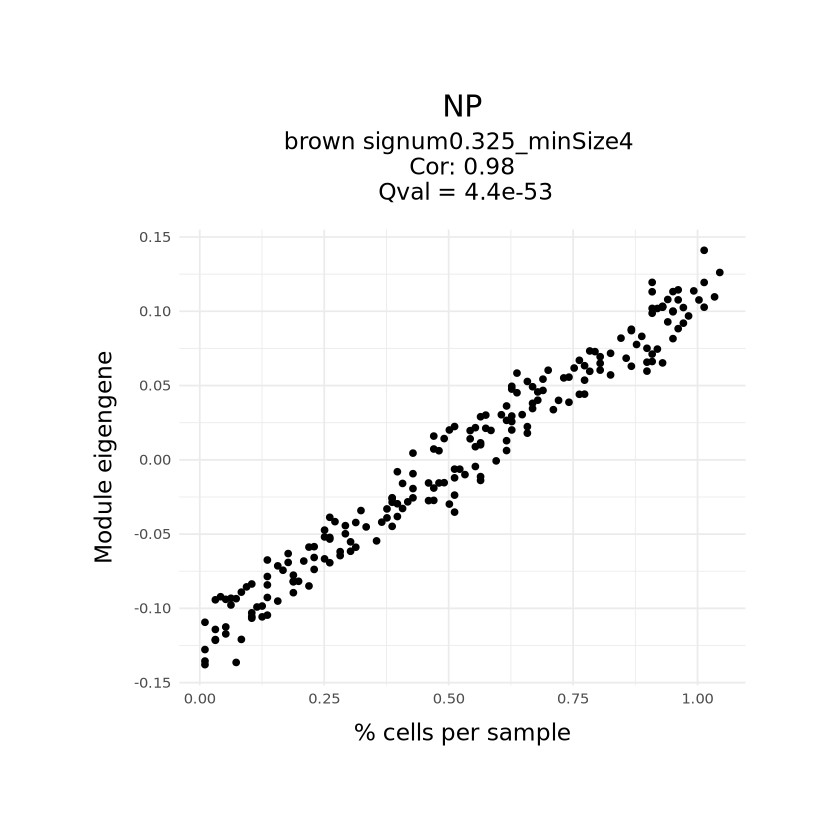

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


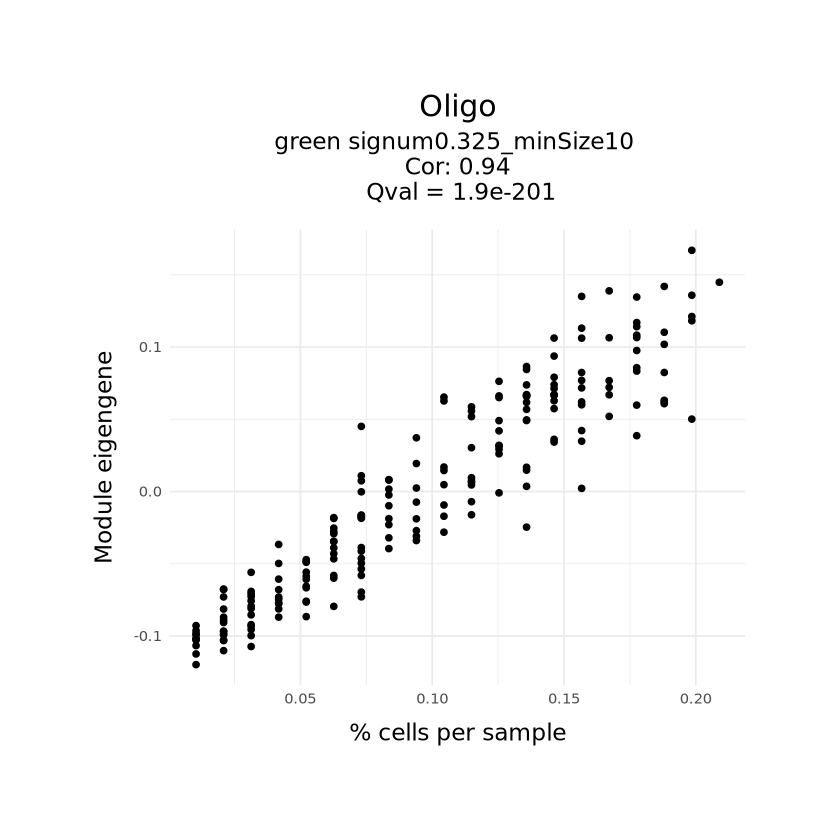

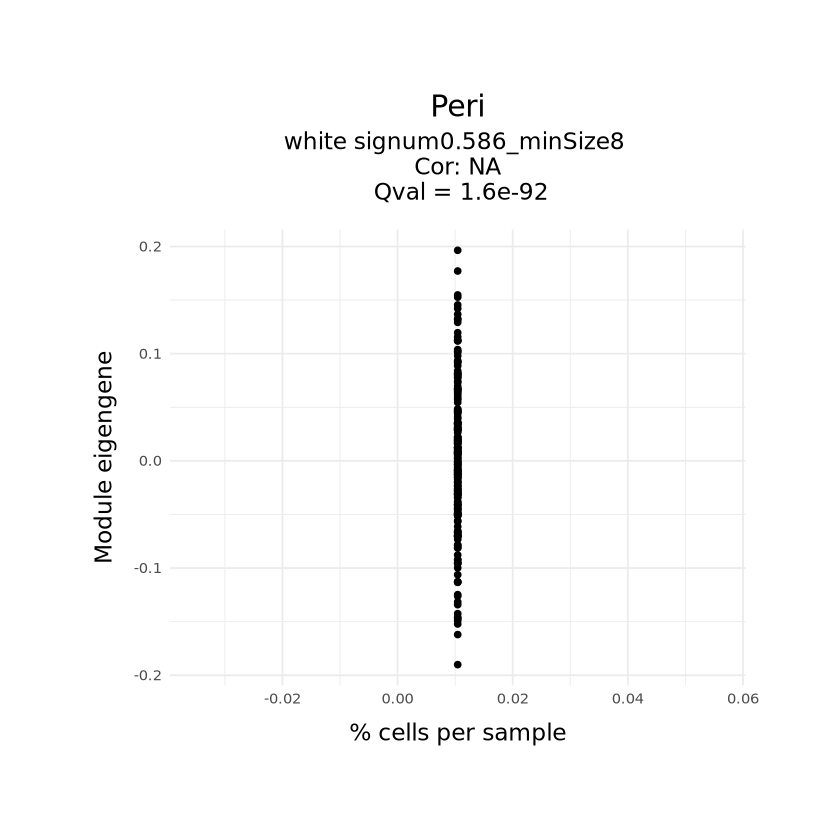

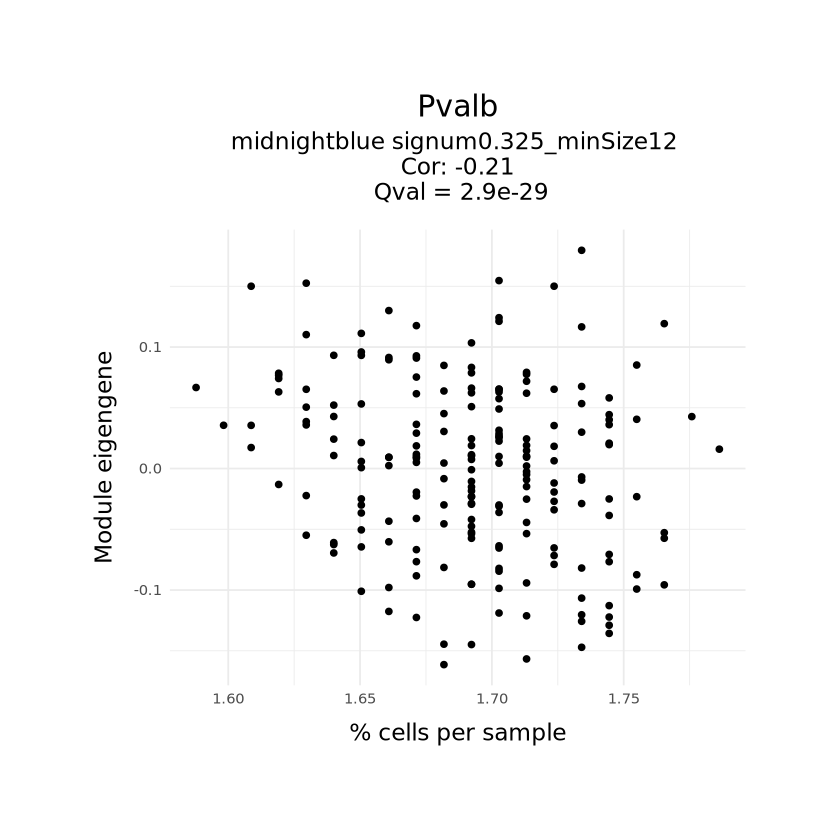

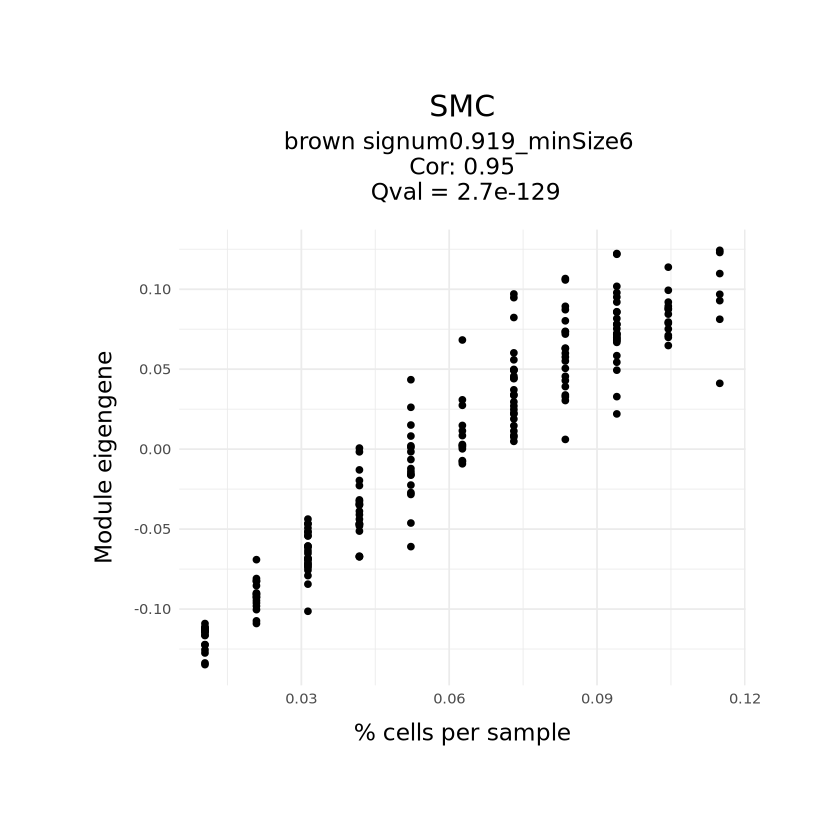

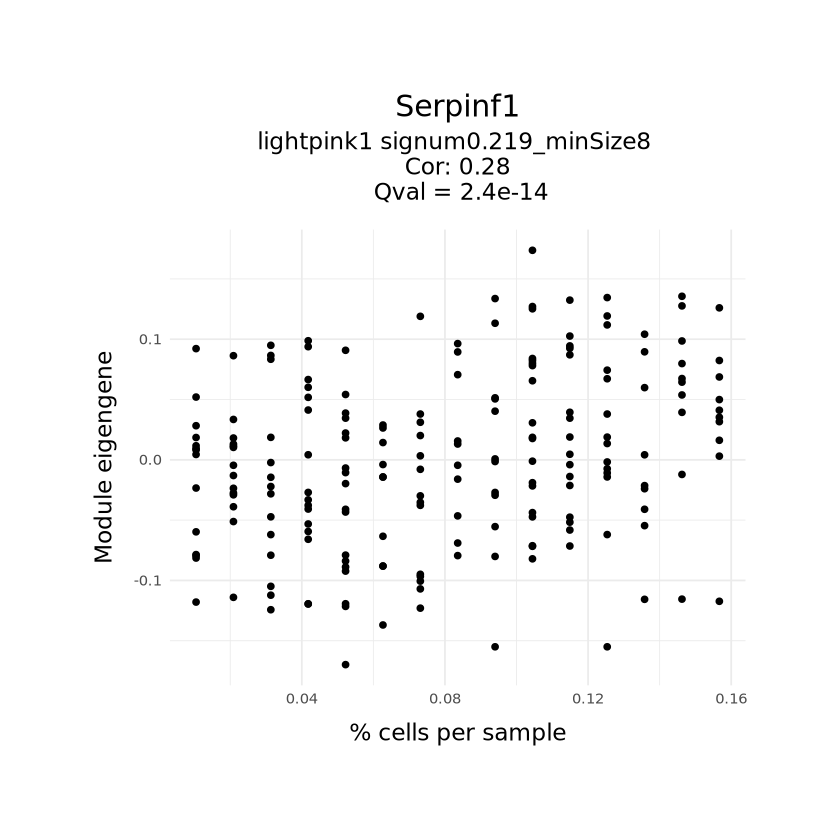

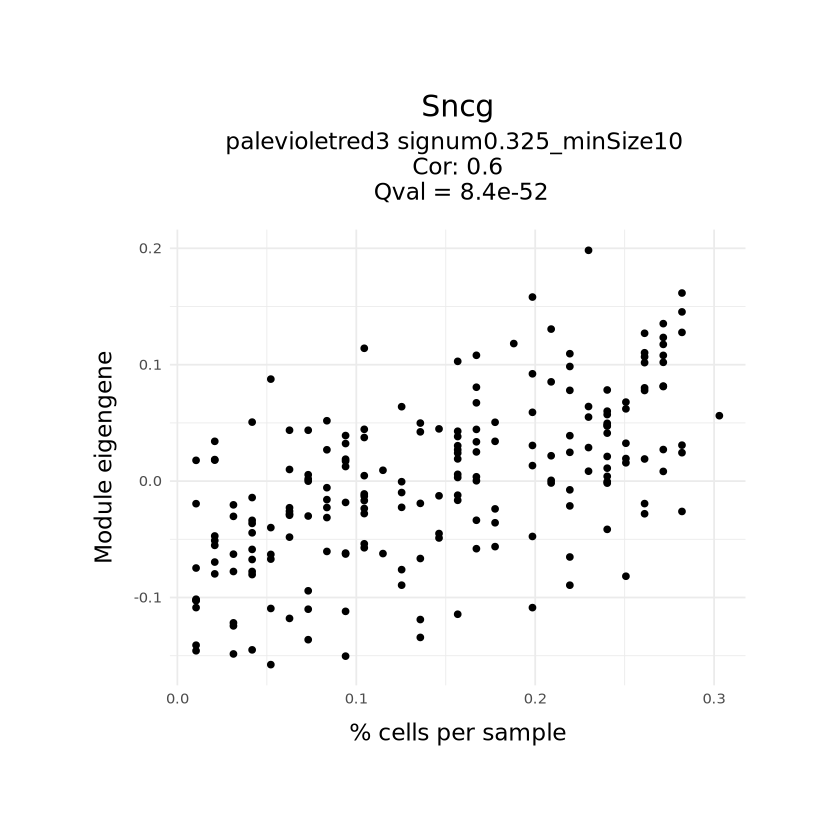

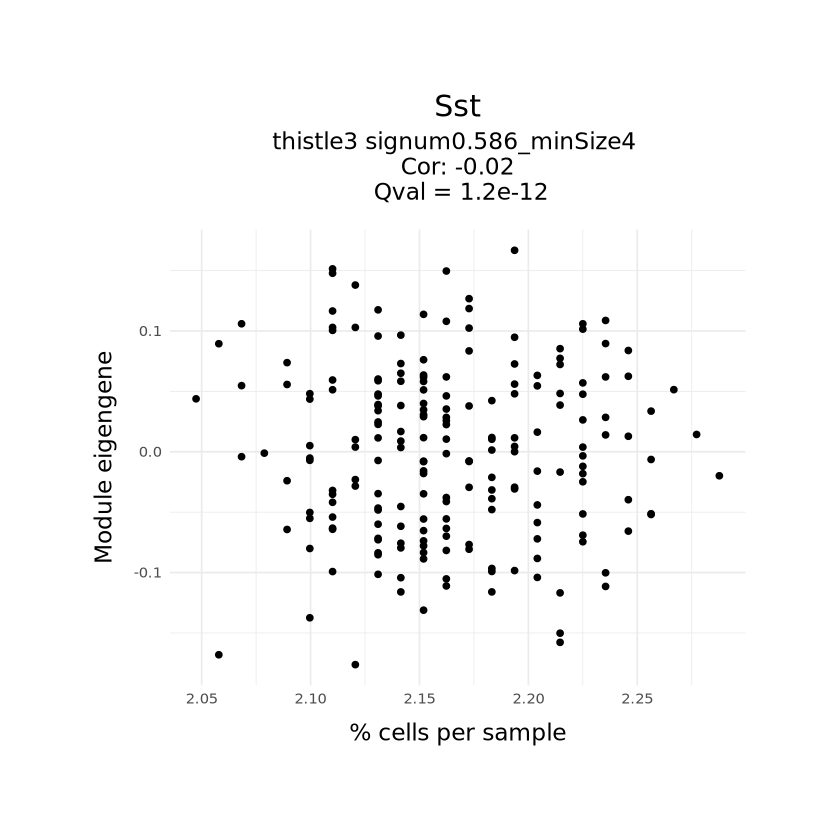

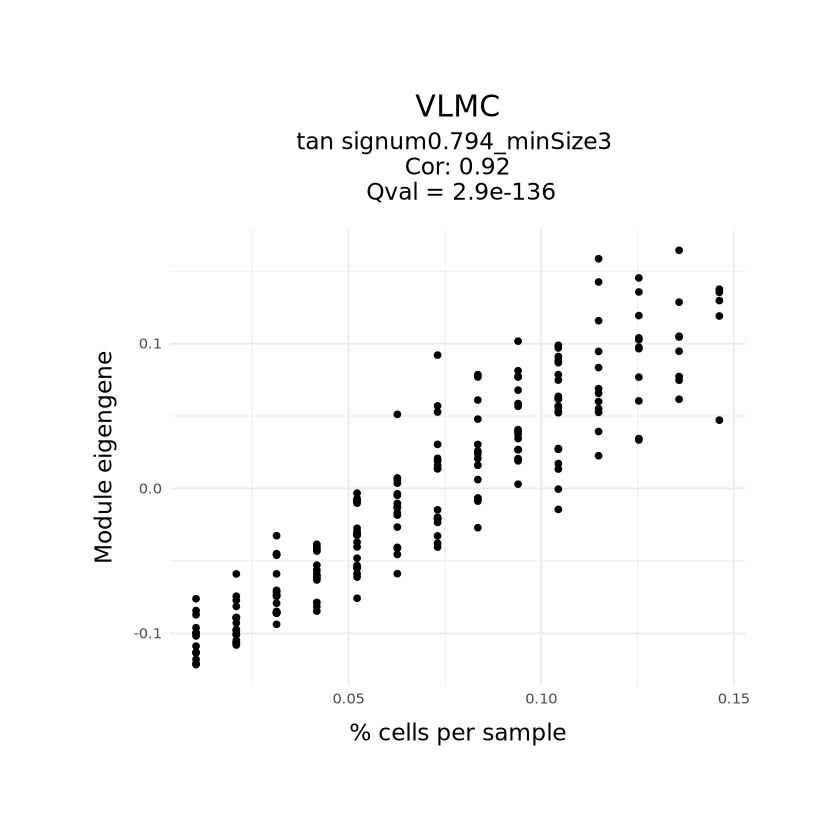

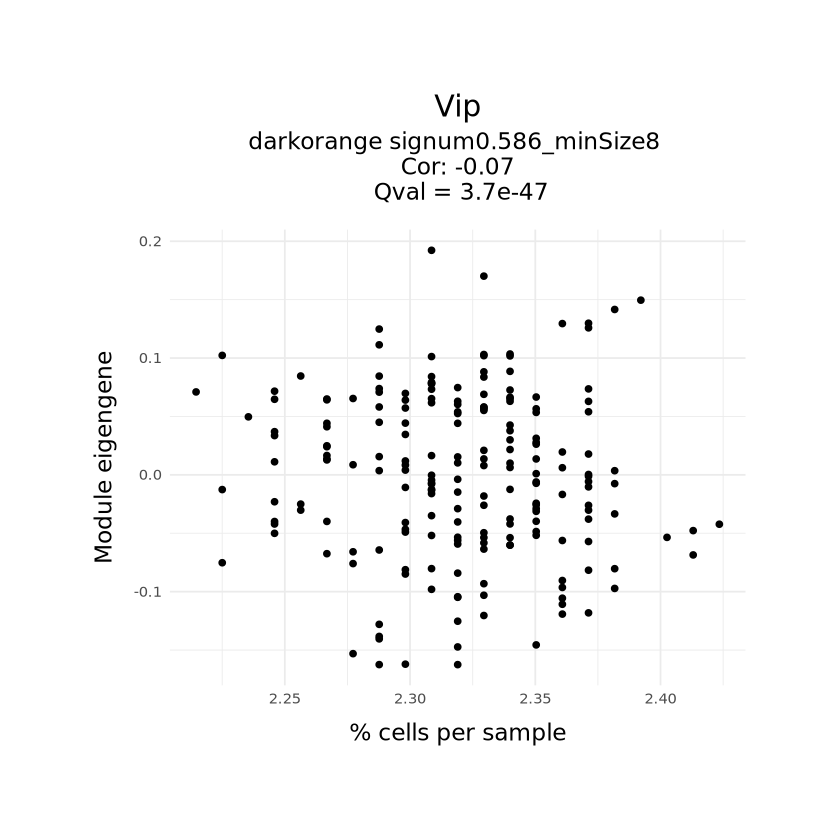

In [55]:
for (i in seq_along(ctypes)) {
    # Get working cell type proportion in each sample
    mask <- pseudobulk_legend$Cell.type == ctypes[i]
    n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
    frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

    # Get eigengene for working cell type module
    mod <- top_qval_mods_df$Module[i]
    ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
    ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

    df <- data.frame(Frac=frac_per_sample, ME=ME_vec)

    corr <- round(cor(frac_per_sample, ME_vec), 2)

    subtitle <- paste(
        top_qval_mods_df$Module[i], top_qval_mods_df$Network_short[i], "\n",
        "Cor:", corr, "\n",
        "Qval =", formatC(top_qval_mods_df$Qval[i], format="e", digits=1) 
    )

    print(
        ggplot(df, aes(x=Frac*100, y=ME)) +
            geom_point() +
            theme(
                plot.title=element_text(hjust=0.5),
                plot.subtitle=element_text(hjust=0.5),
                axis.title.x=element_text(size=14),
                axis.title.y=element_text(size=14)
            ) +
            labs(
                title=ctypes[i], 
                subtitle=subtitle
            ) +
            xlab("% cells per sample") +
            ylab("Module eigengene")
    )
}

In [ ]:
# For (poorly correlated) cell types, see if there exists any module(s) to which they are correlated:

network_dir <- "mouse_ACA_20pcntCells_0.4pcntVar_200samples_log2_Modules"

top_corr_mods_list <- vector(mode="list", length=length(ctypes))

for (i in seq_along(ctypes)) {
    # Get working cell type proportion in each sample
    mask <- pseudobulk_legend$Cell.type == ctypes[i]
    n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
    frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

    # Get eigengene for working cell type module
    mod <- top_qval_mods_df$Module[i]
    ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
    ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

    if (var(frac_per_sample) > 0) {
        networks <- list.dirs(file.path(getwd(), network_dir), full.names=TRUE, recursive=FALSE)
        networks <- networks[lengths(lapply(networks, list.files)) > 0]

        ME_corrs_list <- lapply(seq_along(networks), function(j) {
            ME_path <- list.files(networks[j])[grep("eigengene", list.files(networks[j]))]
            ME_df <- fread(file.path(networks[j], ME_path), data.table=FALSE)

            ME_corrs <- apply(ME_df[,-1, drop=FALSE], 2, function(ME) {
                cor(ME, frac_per_sample)
            })

            module <- names(which.max(ME_corrs))
            max_corr <- ME_corrs[which.max(ME_corrs)]
            
            # Save the network the module came from
            network_id <- sapply(strsplit(networks[j], "/"), function(x) x[length(x)])
            
            data.frame(
                Cell_type=ctypes[i],
                Cor=max_corr,
                Pseudobulk_SD=round(sd(n_cells_per_sample), 2),
                Module=module,
                Network=network_id,
                ME_path=file.path(networks[i], ME_path)
            )
        })
        ME_corrs <- do.call(rbind, ME_corrs_list)
        
        top_corr_mods_list[[i]] <- ME_corrs %>%
            arrange(Network, Module) %>%
            slice_max(Cor, with_ties=F)
    }
}

top_corr_mods_df <- do.call(rbind, top_corr_mods_list)
top_corr_mods_df 

# Round 2 enrichment results (only using unique DE genes)

In [121]:
top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_markers_top_Qval_module.csv")

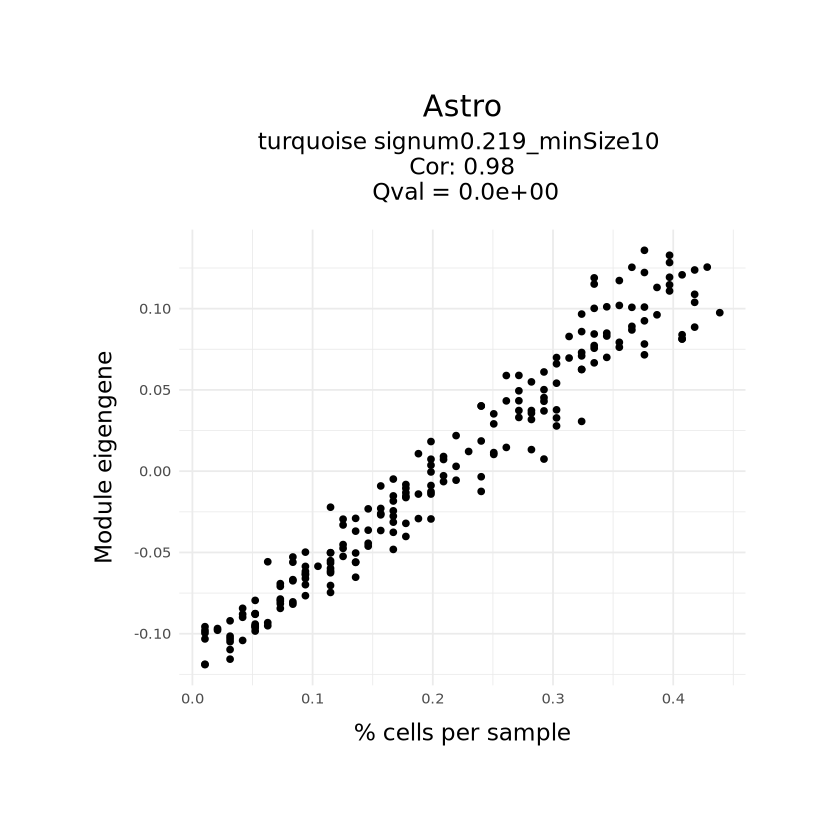

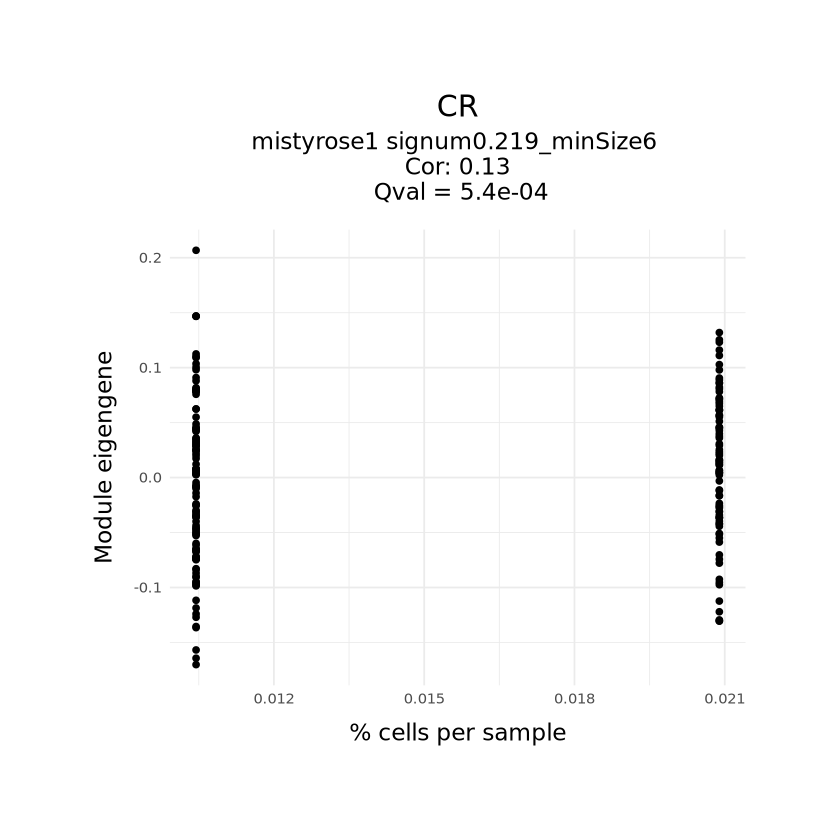

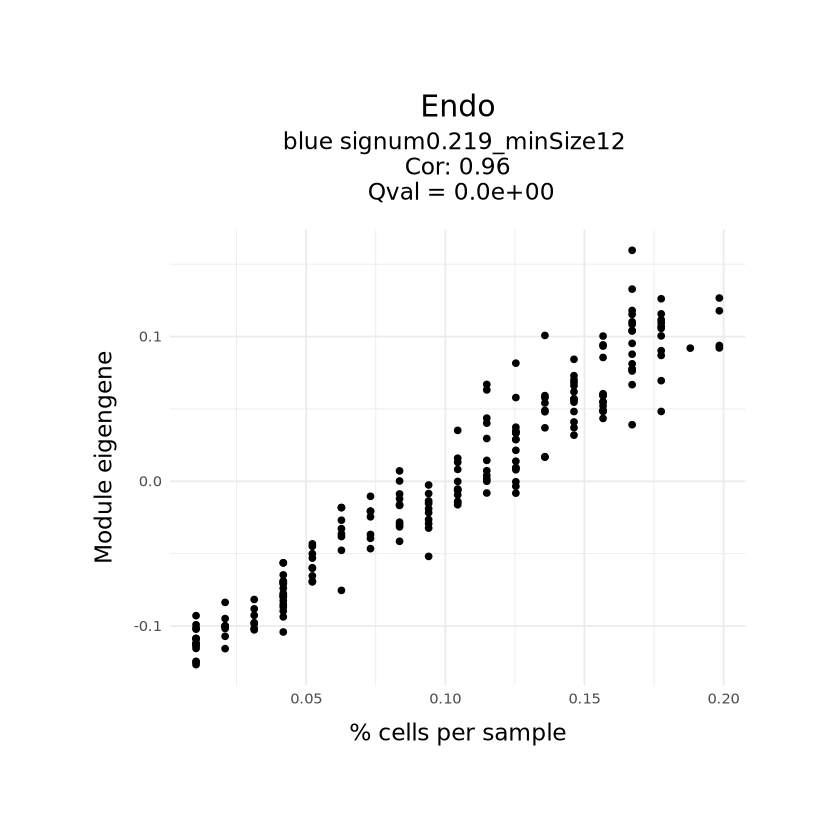

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


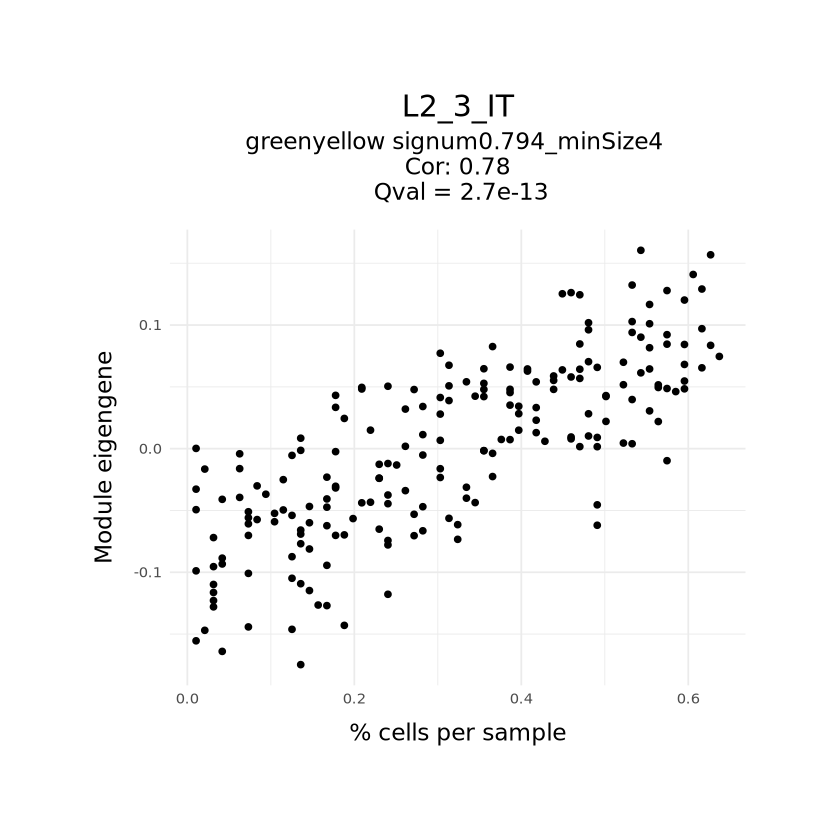

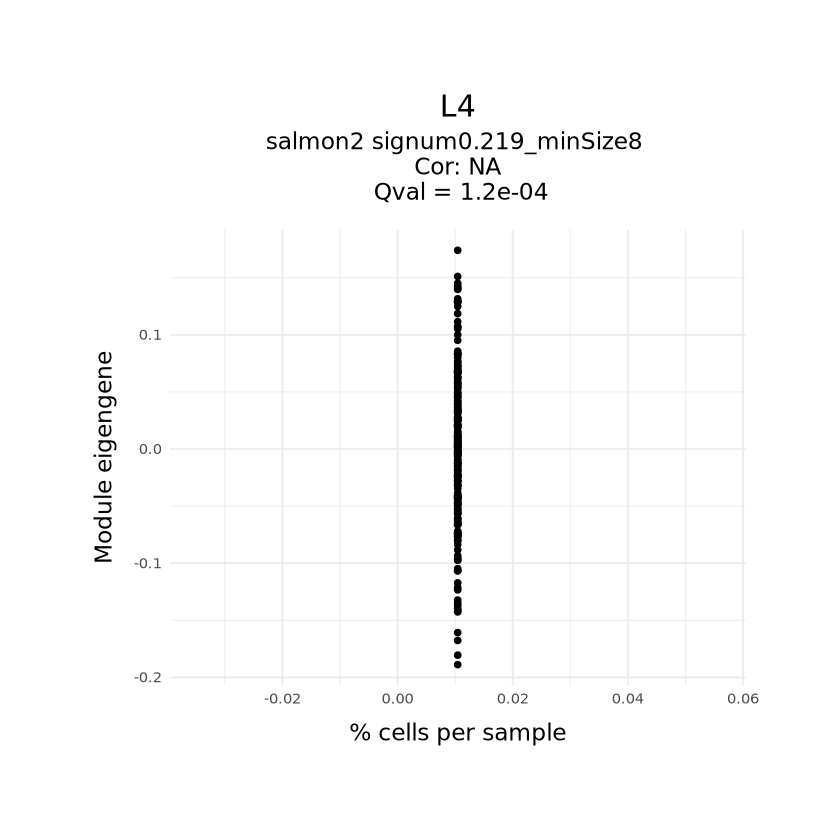

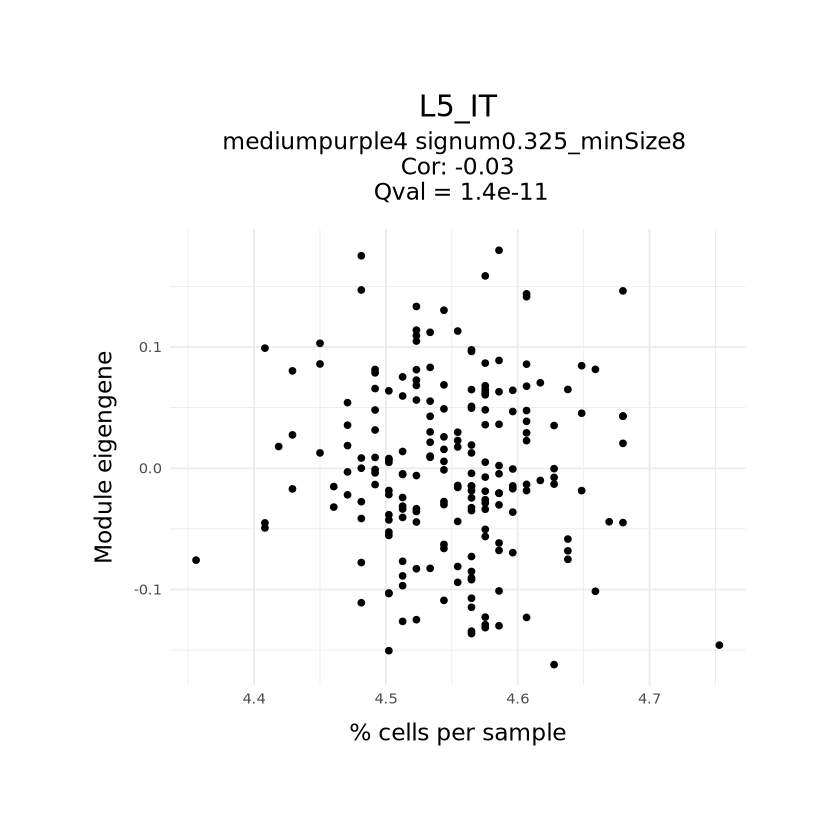

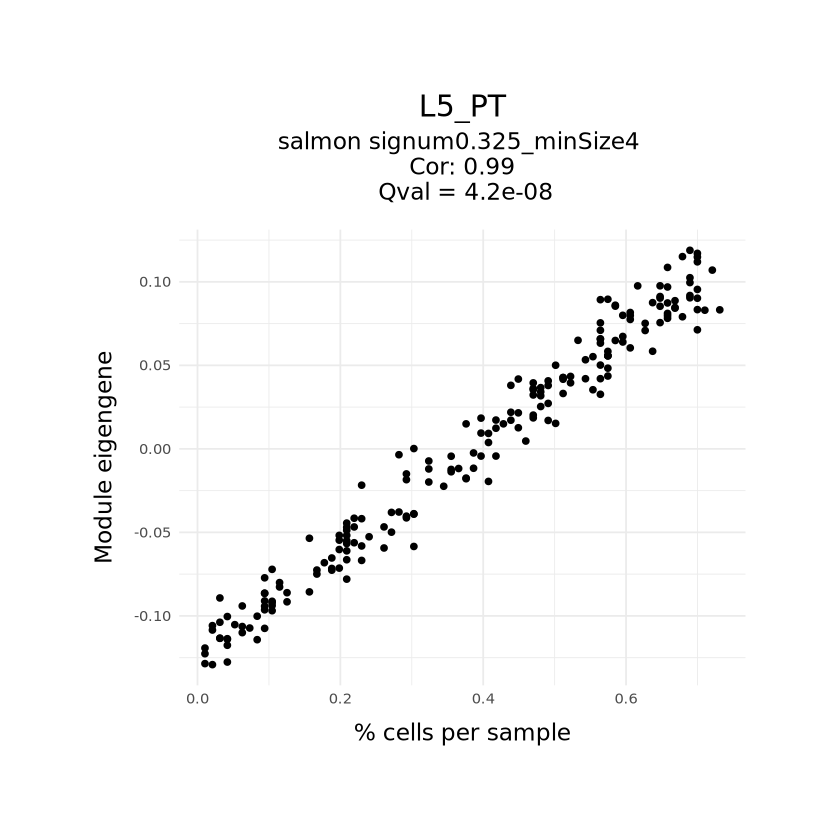

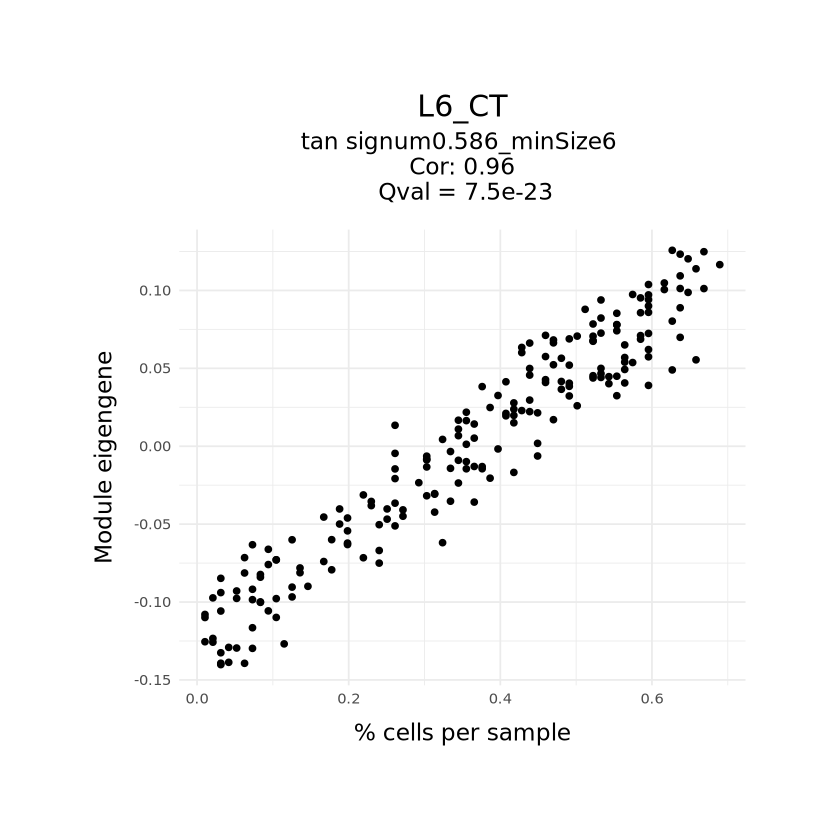

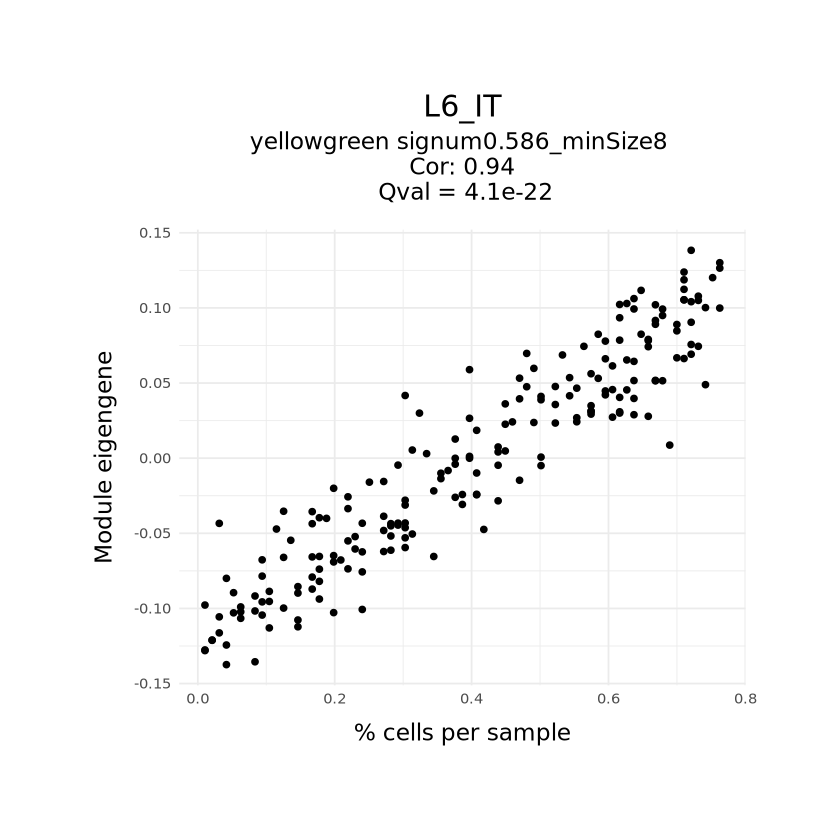

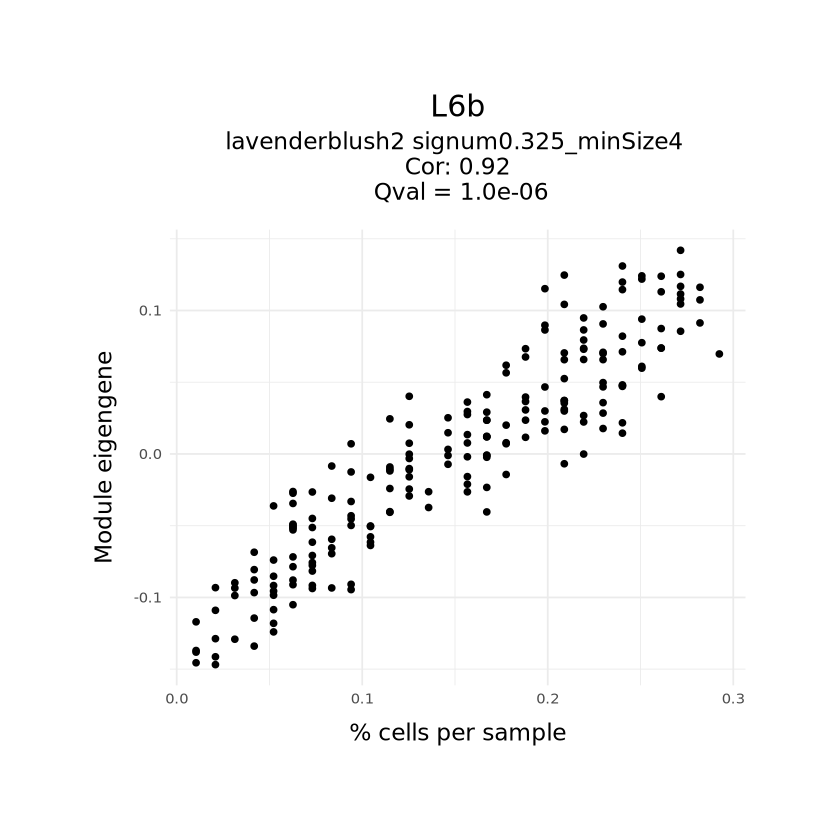

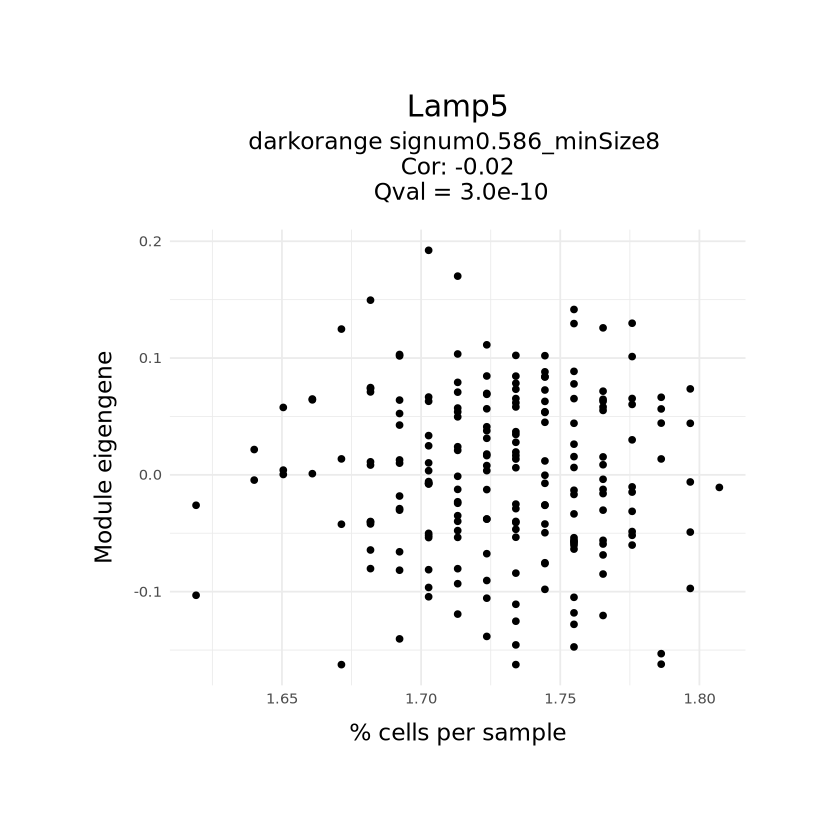

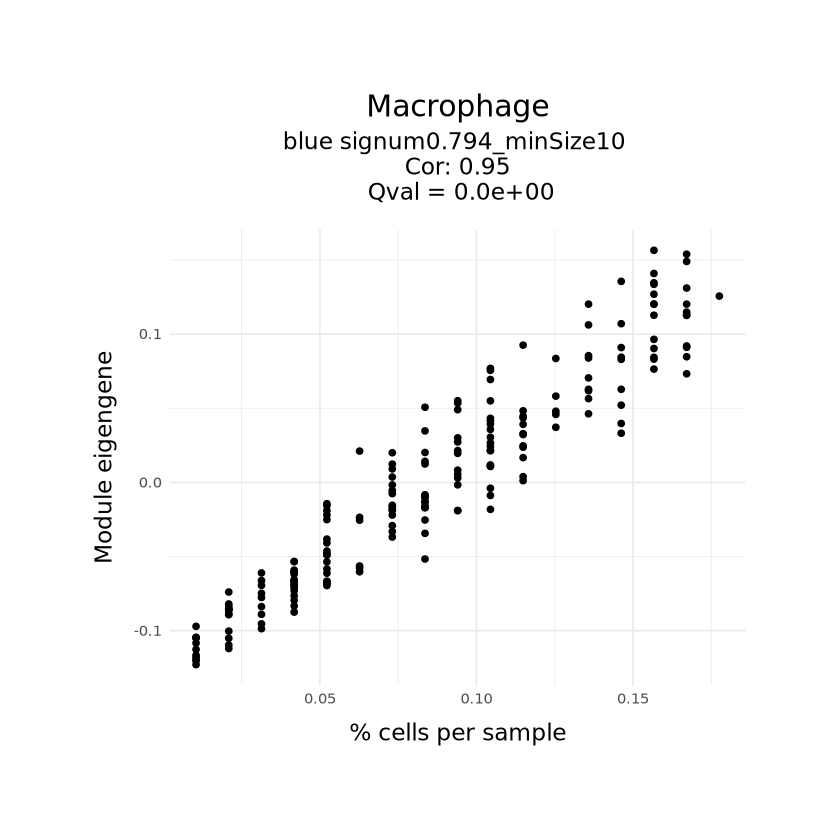

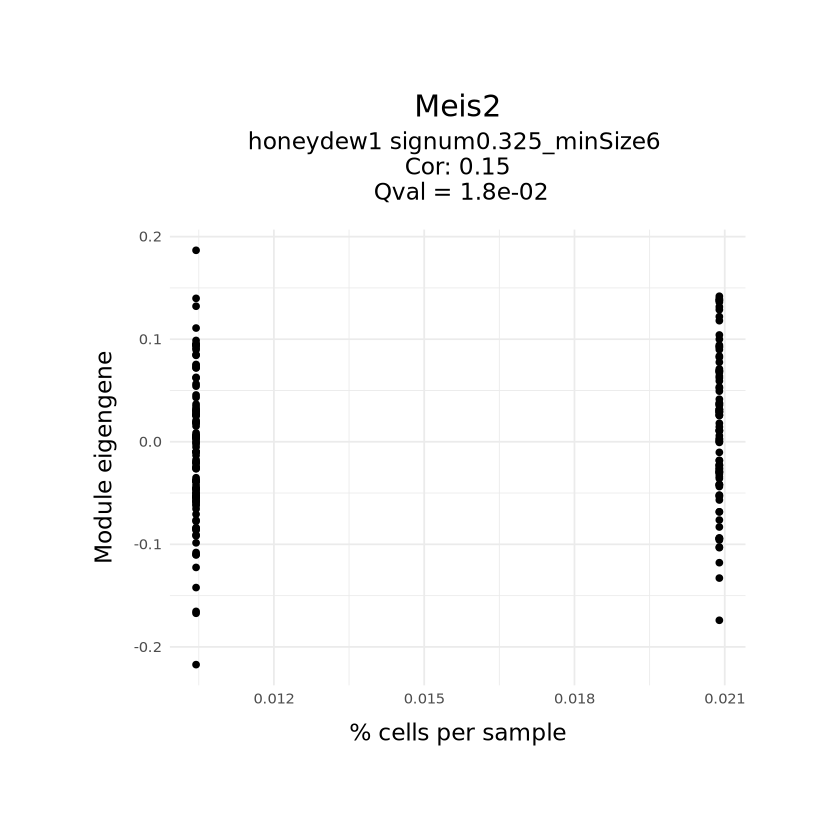

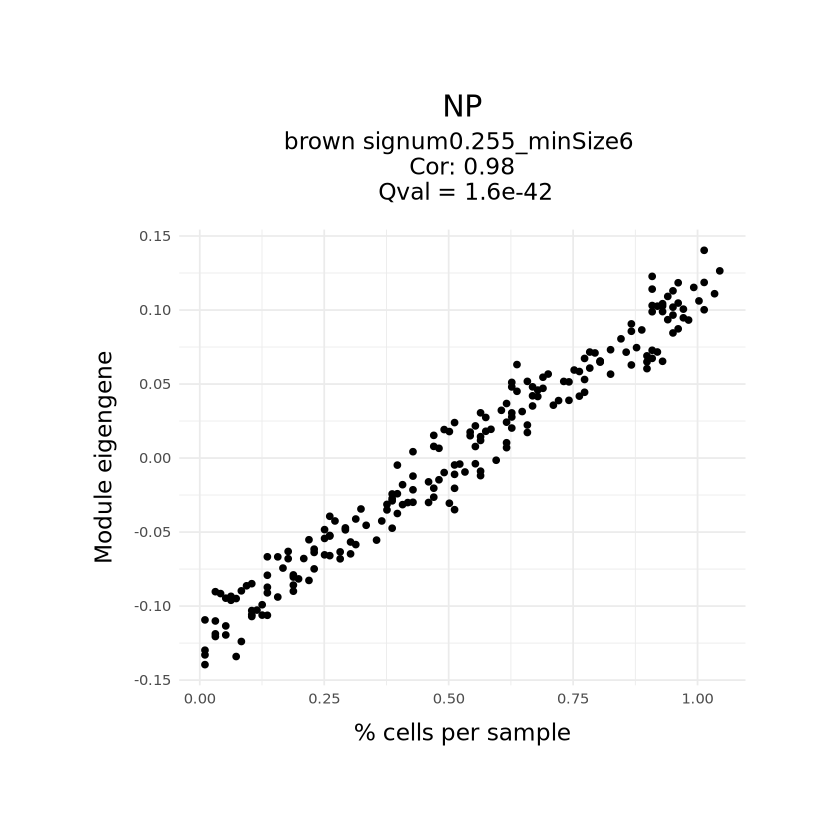

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


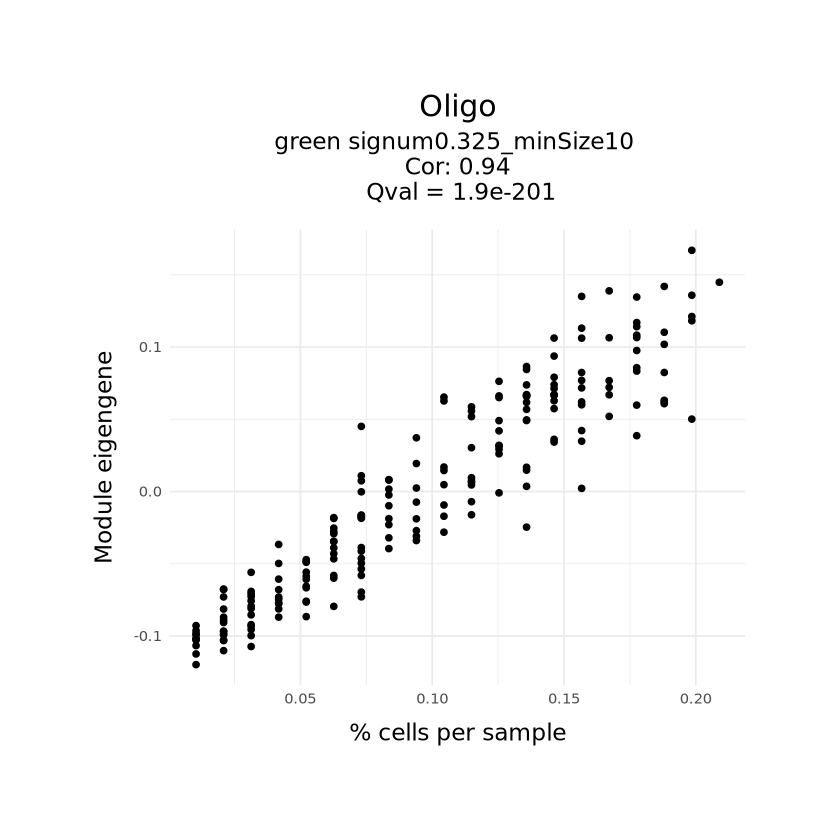

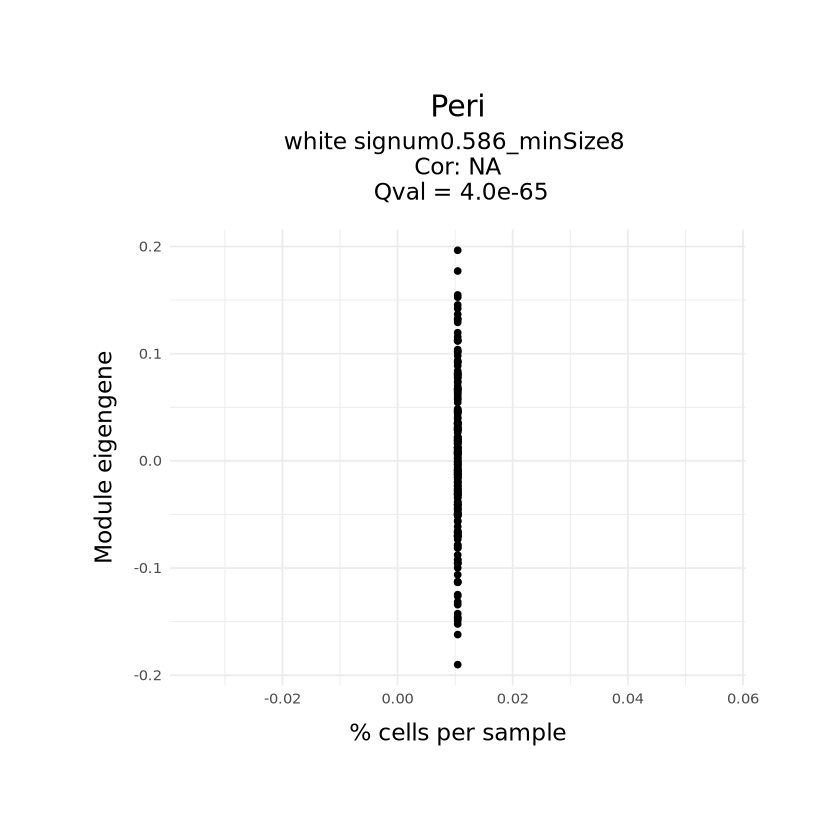

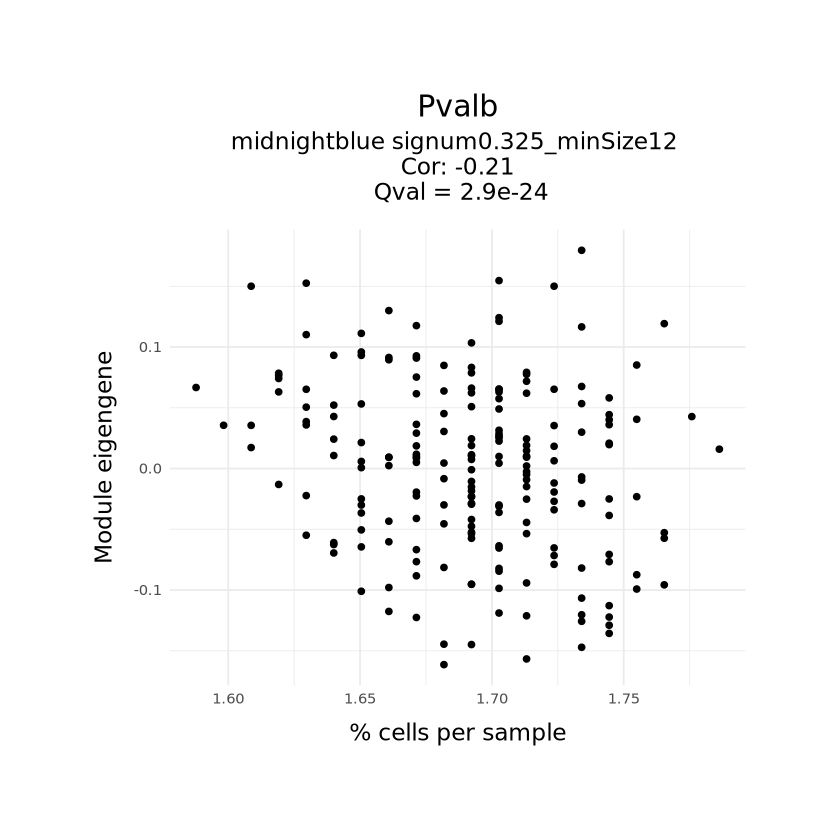

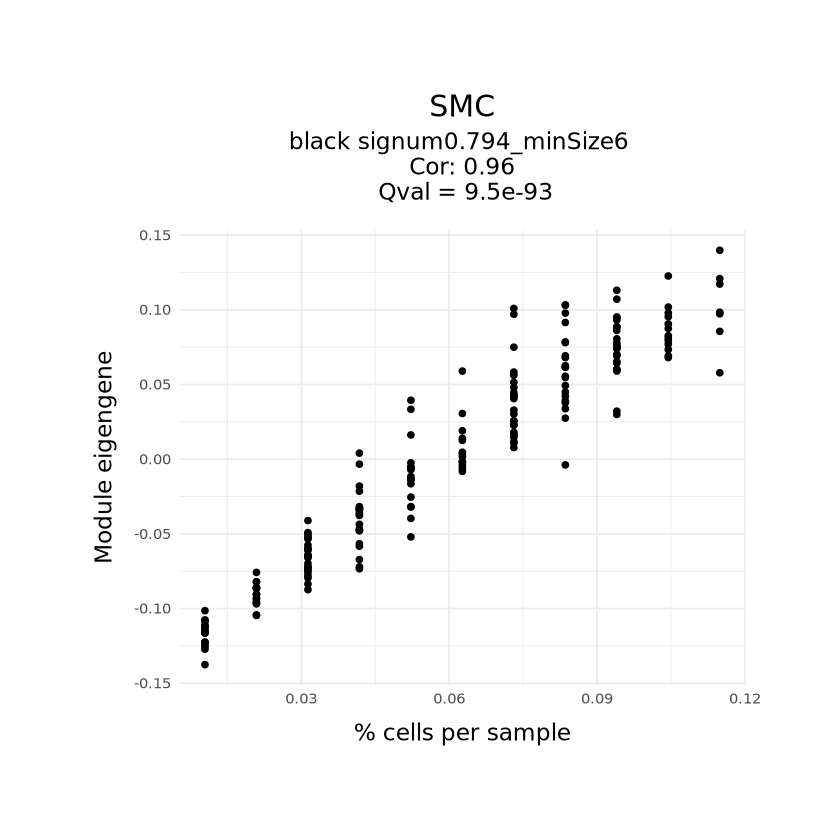

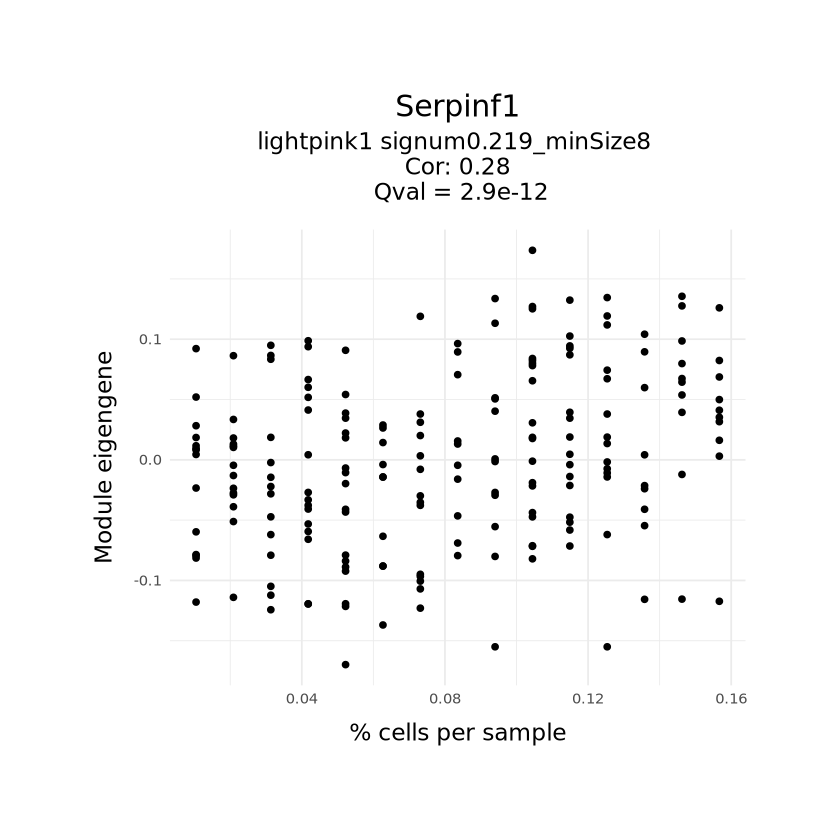

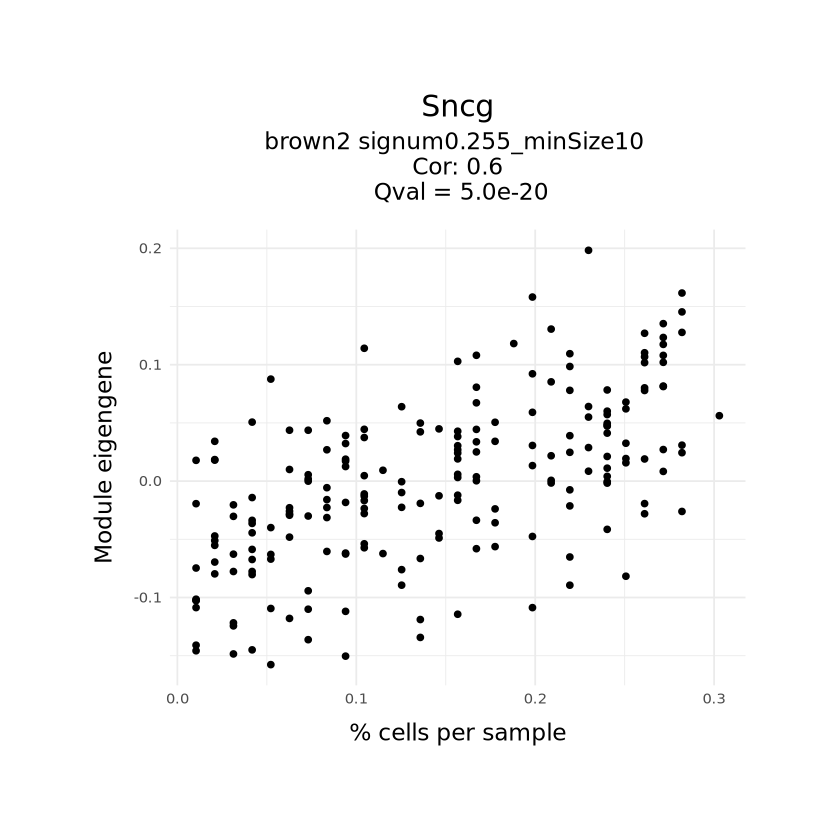

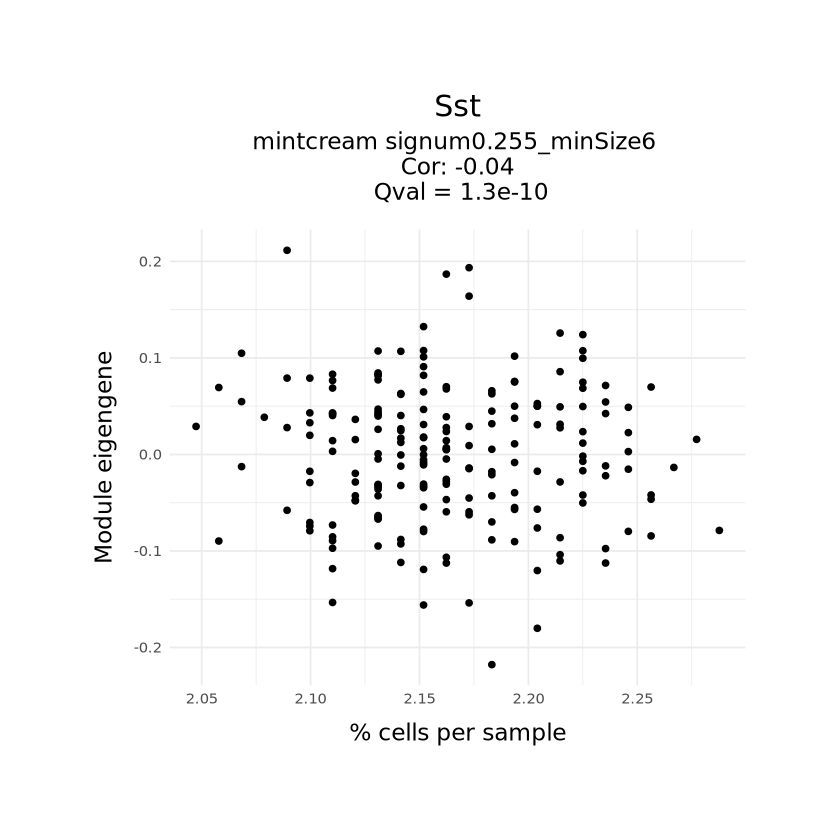

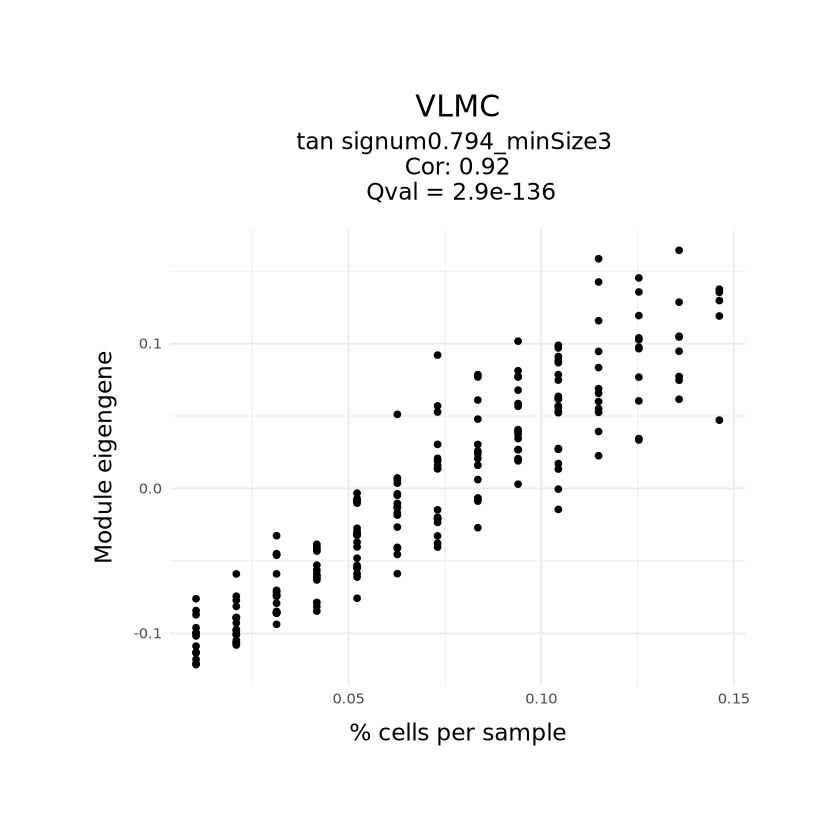

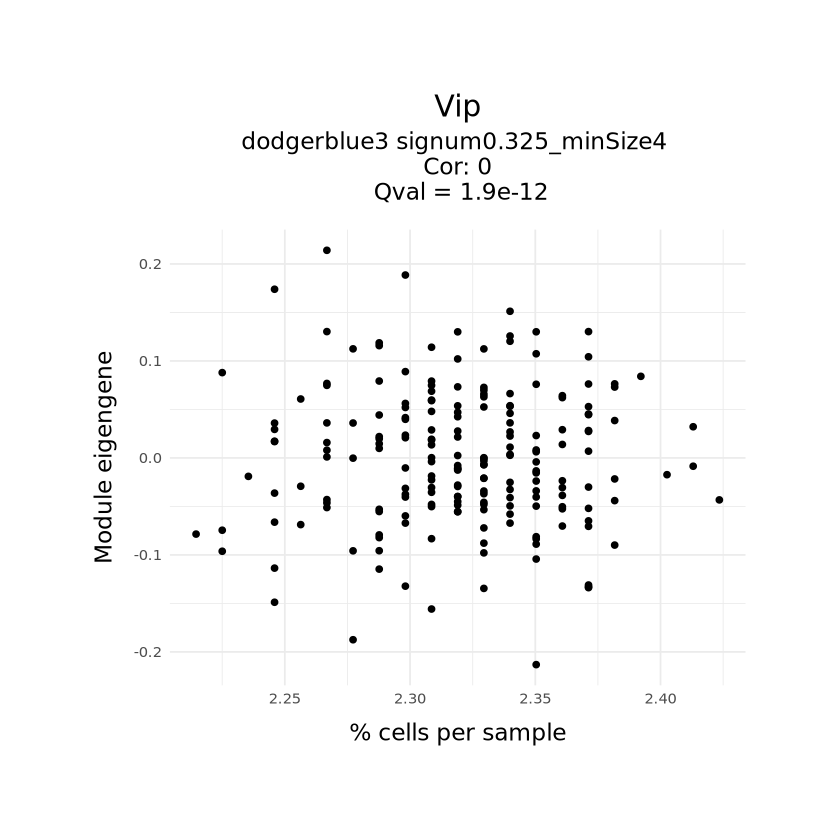

In [122]:
for (i in seq_along(ctypes)) {
    # Get working cell type proportion in each sample
    mask <- pseudobulk_legend$Cell.type == ctypes[i]
    n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
    frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

    # Get eigengene for working cell type module
    mod <- top_qval_mods_df$Module[i]
    ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
    ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

    df <- data.frame(Frac=frac_per_sample, ME=ME_vec)

    corr <- round(cor(frac_per_sample, ME_vec), 2)

    subtitle <- paste(
        top_qval_mods_df$Module[i], top_qval_mods_df$Network_short[i], "\n",
        "Cor:", corr, "\n",
        "Qval =", formatC(top_qval_mods_df$Qval[i], format="e", digits=1) 
    )

    print(
        ggplot(df, aes(x=Frac*100, y=ME)) +
            geom_point() +
            theme(
                plot.title=element_text(hjust=0.5),
                plot.subtitle=element_text(hjust=0.5),
                axis.title.x=element_text(size=14),
                axis.title.y=element_text(size=14)
            ) +
            labs(
                title=ctypes[i], 
                subtitle=subtitle
            ) +
            xlab("% cells per sample") +
            ylab("Module eigengene")
    )
}

# For (poorly correlated) cell types, see if there exists any module(s) to which they are correlated:


In [ ]:
# For (poorly correlated) cell types, see if there exists any module(s) to which they are correlated:

network_dir <- "mouse_ACA_20pcntCells_0.4pcntVar_200samples_log2_Modules"

top_corr_mods_list <- vector(mode="list", length=length(ctypes))

for (i in seq_along(ctypes)) {
    # Get working cell type proportion in each sample
    mask <- pseudobulk_legend$Cell.type == ctypes[i]
    n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
    frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

    # Get eigengene for working cell type module
    mod <- top_qval_mods_df$Module[i]
    ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
    ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

    if (var(frac_per_sample) > 0) {
        networks <- list.dirs(file.path(getwd(), network_dir), full.names=TRUE, recursive=FALSE)
        networks <- networks[lengths(lapply(networks, list.files)) > 0]

        ME_corrs_list <- lapply(seq_along(networks), function(j) {
            ME_path <- list.files(networks[j])[grep("eigengene", list.files(networks[j]))]
            ME_df <- fread(file.path(networks[j], ME_path), data.table=FALSE)

            ME_corrs <- apply(ME_df[,-1, drop=FALSE], 2, function(ME) {
                cor(ME, frac_per_sample)
            })

            module <- names(which.max(ME_corrs))
            max_corr <- ME_corrs[which.max(ME_corrs)]
            
            # Save the network the module came from
            network_id <- sapply(strsplit(networks[j], "/"), function(x) x[length(x)])
            
            data.frame(
                Cell_type=ctypes[i],
                Cor=max_corr,
                Pseudobulk_SD=round(sd(n_cells_per_sample), 2),
                Module=module,
                Network=network_id,
                ME_path=file.path(networks[i], ME_path)
            )
        })
        ME_corrs <- do.call(rbind, ME_corrs_list)
        
        top_corr_mods_list[[i]] <- ME_corrs %>%
            arrange(Network, Module) %>%
            slice_max(Cor, with_ties=F)
    }
}

top_corr_mods_df <- do.call(rbind, top_corr_mods_list)
top_corr_mods_df 